## TransImp configurations and basic usage

This notebook shows how to use different configurations of TransImp for seqFISH imputation.

Input data can be downloaded from [seqfish.tar.gz](https://zenodo.org/record/8214466/files/seqfish.tar.gz?download=1), please extract it with
```sh
tar -xzvf seqfish.tar.gz
```
and change the variable `pre_datapath` in the next cell accordingly.

In [ ]:
import torch
import warnings
import pickle

import squidpy as sq
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import KFold
from transpa.eval_util import calc_corr
from transpa.util import expTransImp, compute_autocorr, plot_genes

warnings.filterwarnings("ignore")
pre_datapath = "../../output/preprocessed_dataset/seqFISH_single_cell.pkl"

seed = 10
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")

### Step 1. Load preprocessed SeqFISH ST and reference datasets

In [2]:
with open(pre_datapath, 'rb') as infile:
    spa_adata, scrna_adata, raw_spatial_df, raw_scrna_df, raw_shared_gene = pickle.load(infile)
    

### Step 2. Retrieve Leiden cell clusters from preprocessed scRNAseq reference.

Imputation uncertainty estimation requires local bootstraping with cell clusters on reference single cell data (Leiden method as default). 

In [3]:
cls_key = 'leiden'
classes = scrna_adata.obs[cls_key]
ct_list = np.unique(classes)

### Step 3. Five-fold cross validation for 4 configurations of TransImp

The four configurations of TransImp are
- TransImpLR: Translation with low-rank mapping matrix, and cell as SC gene profile
- TransImpCls: Translation with full-rank mapping matrix, and cell clusters (Leiden clusters) as SC gene profile
- TransImpSpa: Spatial regularization added to TransImpLR training.
- TransImpClsSpa: Spatial regularization added to TransImpCls training.

Here we use predicted uncertainty scores from TransImpLR. By setting `n_simulation=200` we activate uncertainty prediction module with 200 local bootstrapping samples. The module is turned off with `n_simulation=None` in default.

>Note the strength of spatial regularization can be controlled via hyper-parameter `wt_spa` (default 1.0)

In [4]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)
kf.get_n_splits(raw_shared_gene)

uncertainty_score = []
test_gene_set = []
df_transImpCls = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpLR = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)
df_transImpClsSpa = pd.DataFrame(np.zeros((spa_adata.n_obs, len(raw_shared_gene))), columns=raw_shared_gene)

for idx, (train_ind, test_ind) in enumerate(kf.split(raw_shared_gene)):    
    print(f"\n===== Fold {idx+1} =====\nNumber of train genes: {len(train_ind)}, Number of test genes: {len(test_ind)}")
    train_gene = raw_shared_gene[train_ind]
    test_gene  = raw_shared_gene[test_ind]
    
    test_spatial_df = raw_spatial_df[test_gene]
    spatial_df = raw_spatial_df[train_gene]
    scrna_df   = raw_scrna_df

    # TransImpLR, low-rank version with raw cells as gene profile
    transImpRes = expTransImp(
                    df_ref=raw_scrna_df,
                    df_tgt=raw_spatial_df,
                    train_gene=train_gene,
                    test_gene=test_gene,
                    n_simulation=200,
                    signature_mode='cell',
                    mapping_mode='lowrank',
                    classes=classes,
                    n_epochs=2000,
                    seed=seed,
                    device=device
    )
    
    df_transImpLR[test_gene] = transImpRes[0]
    uncertainty_score.append(transImpRes[1])
    test_gene_set.append(test_gene)
    
    corr_transImpLR_res = calc_corr(raw_spatial_df, df_transImpLR, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpLR_res)} (TransImpLR)')

    # TransImpSpa, low-rank version with raw cells as gene profile, spatially-regularized
    df_transImpSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                signature_mode='cell',
                mapping_mode='lowrank',
                wt_spa=0.1,
                n_epochs=2000,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpSpa, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpSpa_res)} (TransImpSpa)')
    
    # TransImpCls, full-rank version with Leiden cluster as gene profile
    df_transImpCls[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                n_epochs=2000,
                signature_mode='cluster',
                mapping_mode='full',
                seed=seed,
                device=device)
    
    corr_transImp_res = calc_corr(raw_spatial_df, df_transImpCls, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImp_res)} (TransImpCls)')

    # TransImpClsSpa, full-rank version with Leiden cluster as gene profile, spatially-regularized
    df_transImpClsSpa[test_gene] = expTransImp(
                df_ref=raw_scrna_df,
                df_tgt=raw_spatial_df,
                train_gene=train_gene,
                test_gene=test_gene,
                ct_list=ct_list,
                classes=classes,
                spa_adj=spa_adata.obsp['spatial_connectivities'].tocoo(),
                signature_mode='cluster',
                mapping_mode='full',
                wt_spa=0.1,
                n_epochs=2000,
                seed=seed,
                device=device)

    corr_transImpSpa_res = calc_corr(raw_spatial_df, df_transImpClsSpa, test_gene)
    print(f'fold {idx}, median cosine similarity: {np.median(corr_transImpSpa_res)} (TransImpClsSpa)')




===== Fold 1 =====
Number of train genes: 280, Number of test genes: 71


[TransImp] Epoch: 2000/2000, loss: 0.733447, (IMP) 0.733447: 100%|██████████| 2000/2000 [00:29<00:00, 68.02it/s]


fold 0, median cosine similarity: 0.44627663493156433 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.737318, (IMP) 0.735251, (SPA) 0.1 x 0.020668: 100%|██████████| 2000/2000 [00:38<00:00, 52.53it/s]


fold 0, median cosine similarity: 0.4457996189594269 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.905224, (IMP) 0.905224: 100%|██████████| 2000/2000 [00:16<00:00, 120.57it/s]


fold 0, median cosine similarity: 0.44672921299934387 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.908038, (IMP) 0.906186, (SPA) 0.1 x 0.018520: 100%|██████████| 2000/2000 [00:28<00:00, 70.31it/s]


fold 0, median cosine similarity: 0.446478933095932 (TransImpClsSpa)

===== Fold 2 =====
Number of train genes: 281, Number of test genes: 70


[TransImp] Epoch: 2000/2000, loss: 0.740535, (IMP) 0.740535: 100%|██████████| 2000/2000 [00:25<00:00, 78.81it/s]


fold 1, median cosine similarity: 0.4850706607103348 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.748896, (IMP) 0.746898, (SPA) 0.1 x 0.019981: 100%|██████████| 2000/2000 [00:37<00:00, 53.48it/s]


fold 1, median cosine similarity: 0.48205576837062836 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.919692, (IMP) 0.919692: 100%|██████████| 2000/2000 [00:15<00:00, 125.54it/s]


fold 1, median cosine similarity: 0.467602014541626 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.922587, (IMP) 0.920695, (SPA) 0.1 x 0.018920: 100%|██████████| 2000/2000 [00:27<00:00, 71.68it/s]


fold 1, median cosine similarity: 0.46698686480522156 (TransImpClsSpa)

===== Fold 3 =====
Number of train genes: 281, Number of test genes: 70


[TransImp] Epoch: 2000/2000, loss: 0.756565, (IMP) 0.756565: 100%|██████████| 2000/2000 [00:25<00:00, 78.87it/s]


fold 2, median cosine similarity: 0.5312486588954926 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.764006, (IMP) 0.762071, (SPA) 0.1 x 0.019345: 100%|██████████| 2000/2000 [00:37<00:00, 53.74it/s]


fold 2, median cosine similarity: 0.525227278470993 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.936510, (IMP) 0.936510: 100%|██████████| 2000/2000 [00:15<00:00, 125.81it/s]


fold 2, median cosine similarity: 0.5168916583061218 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.939366, (IMP) 0.937490, (SPA) 0.1 x 0.018759: 100%|██████████| 2000/2000 [00:27<00:00, 71.72it/s]


fold 2, median cosine similarity: 0.5125251412391663 (TransImpClsSpa)

===== Fold 4 =====
Number of train genes: 281, Number of test genes: 70


[TransImp] Epoch: 2000/2000, loss: 0.743996, (IMP) 0.743996: 100%|██████████| 2000/2000 [00:25<00:00, 79.12it/s]


fold 3, median cosine similarity: 0.531928151845932 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.751274, (IMP) 0.749144, (SPA) 0.1 x 0.021301: 100%|██████████| 2000/2000 [00:37<00:00, 53.55it/s]


fold 3, median cosine similarity: 0.5265305936336517 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.918628, (IMP) 0.918628: 100%|██████████| 2000/2000 [00:15<00:00, 125.70it/s]


fold 3, median cosine similarity: 0.48475973308086395 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.921646, (IMP) 0.919681, (SPA) 0.1 x 0.019651: 100%|██████████| 2000/2000 [00:27<00:00, 71.69it/s]


fold 3, median cosine similarity: 0.4819002151489258 (TransImpClsSpa)

===== Fold 5 =====
Number of train genes: 281, Number of test genes: 70


[TransImp] Epoch: 2000/2000, loss: 0.762444, (IMP) 0.762444: 100%|██████████| 2000/2000 [00:25<00:00, 78.36it/s]


fold 4, median cosine similarity: 0.5365848541259766 (TransImpLR)


[TransImp] Epoch: 2000/2000, loss: 0.765744, (IMP) 0.763631, (SPA) 0.1 x 0.021127: 100%|██████████| 2000/2000 [00:37<00:00, 53.58it/s]


fold 4, median cosine similarity: 0.5325645506381989 (TransImpSpa)


[TransImp] Epoch: 2000/2000, loss: 0.926034, (IMP) 0.926034: 100%|██████████| 2000/2000 [00:15<00:00, 126.13it/s]


fold 4, median cosine similarity: 0.5106758773326874 (TransImpCls)


[TransImp] Epoch: 2000/2000, loss: 0.929062, (IMP) 0.927045, (SPA) 0.1 x 0.020179: 100%|██████████| 2000/2000 [00:27<00:00, 71.72it/s]


fold 4, median cosine similarity: 0.506095826625824 (TransImpClsSpa)


### Step 4. Create adata objects and compute spatial autocorrelation with Squidpy

In [5]:
dict_df = {"TransImpLR":df_transImpLR, 
           "TransImpCls":df_transImpCls,
           "TransImpSpa":df_transImpSpa, 
           "TransImpClsSpa":df_transImpClsSpa,
           "truth":raw_spatial_df[raw_shared_gene].copy(),
        }
sq.gr.spatial_autocorr(
    spa_adata,
    n_jobs=10,
)
dict_adata = {name: compute_autocorr(spa_adata[:, raw_shared_gene].copy(), df) for name, df in dict_df.items()}

### Step 5. Plot uncertainty score quantiles vs median cosine similarity score of genes below quantile 

36
71
106
141
176
211
246
281
316
351


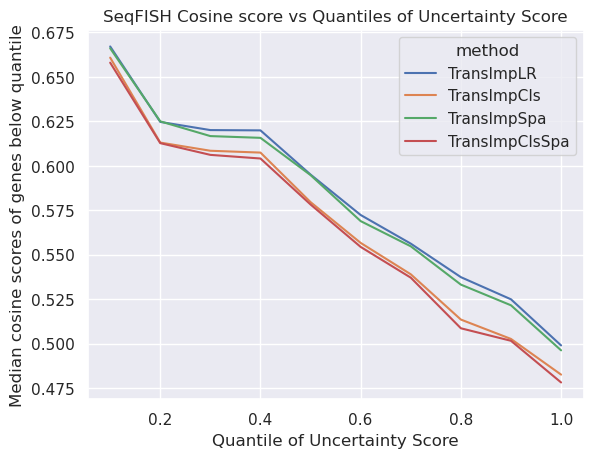

In [6]:
df_pred_uncertainty = pd.DataFrame(np.zeros((1, len(raw_shared_gene))), columns=raw_shared_gene)
for _test_genes, _sim_res in zip(test_gene_set, uncertainty_score):
    df_pred_uncertainty[_test_genes] = _sim_res

res = []
quantiles = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
for _quantile in quantiles:
    qt = np.quantile(df_pred_uncertainty.values, _quantile)
    sel = (df_pred_uncertainty <= qt).values.flatten()
    print(sel.sum())
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_transImpLR, raw_shared_gene[sel])), "method":"TransImpLR", "quantile":_quantile})
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_transImpCls, raw_shared_gene[sel])), "method":"TransImpCls", "quantile":_quantile})
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_transImpSpa, raw_shared_gene[sel])), "method":"TransImpSpa", "quantile":_quantile})
    res.append({"cos_score":np.median(calc_corr(raw_spatial_df, df_transImpClsSpa, raw_shared_gene[sel])), "method":"TransImpClsSpa", "quantile":_quantile})

sns.set_theme(rc={'figure.dpi': 100})
sns.lineplot(pd.DataFrame(res),x='quantile',y="cos_score", hue="method" ).set(xlabel ="Quantile of Uncertainty Score", ylabel = "Median cosine scores of genes below quantile", title ='SeqFISH Cosine score vs Quantiles of Uncertainty Score');

### Step 6. Plot observed genes annotated with Moran's I (M.I.)

               I  pval_norm  var_norm  pval_norm_fdr_bh
Slc4a1  0.199730        0.0  0.000006               0.0
Cdh5    0.189833        0.0  0.000006               0.0
Krt18   0.324988        0.0  0.000006               0.0


<Figure size 2000x2000 with 0 Axes>

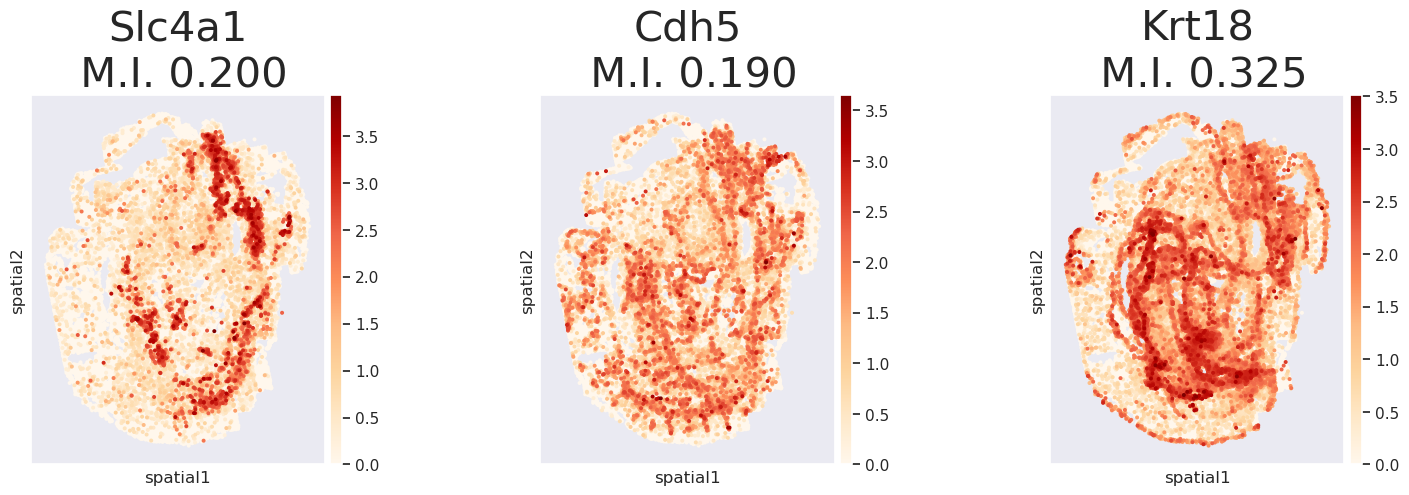

In [7]:
plot_genes(['Slc4a1', 'Cdh5', 'Krt18'], spa_adata, is_I=True, dpi=100)

### Step 7. Plot TransImpLR imputed genes

                  I  pval_norm  var_norm  pval_norm_fdr_bh
gene_name                                                 
Slc4a1     0.242234        0.0  0.000006               0.0
Cdh5       0.219649        0.0  0.000006               0.0
Krt18      0.387271        0.0  0.000006               0.0


<Figure size 2000x2000 with 0 Axes>

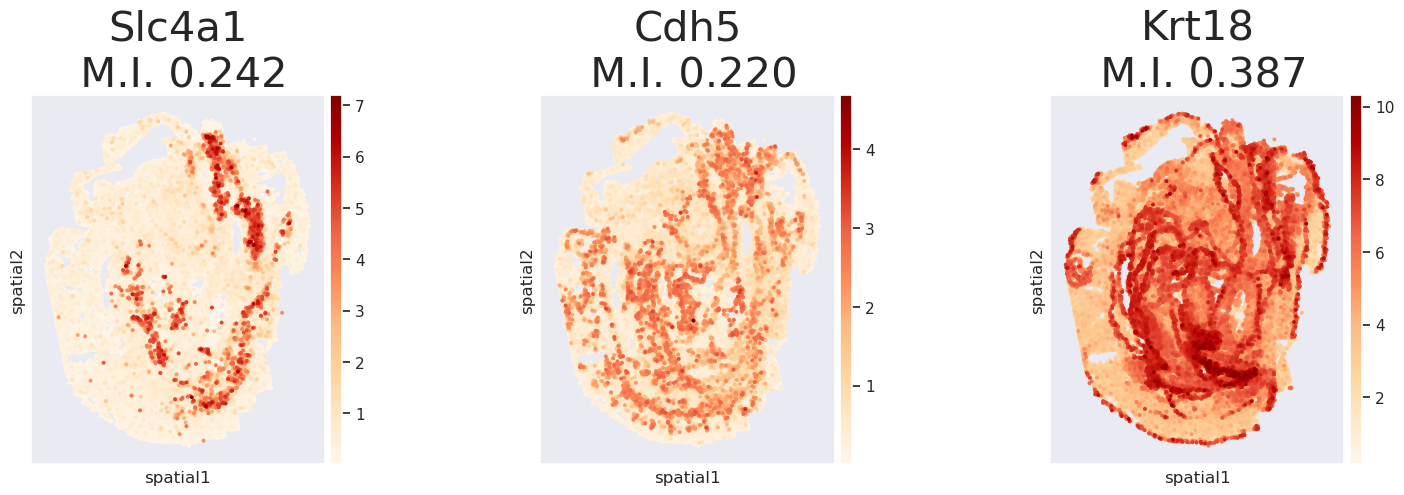

In [8]:
plot_genes(['Slc4a1', 'Cdh5', 'Krt18'], dict_adata['TransImpLR'], is_I=True, dpi=100)

### Step 8. Plot TransImpSpa imputed genes

                  I  pval_norm  var_norm  pval_norm_fdr_bh
gene_name                                                 
Slc4a1     0.219994        0.0  0.000006               0.0
Cdh5       0.175437        0.0  0.000006               0.0
Krt18      0.324220        0.0  0.000006               0.0


<Figure size 2000x2000 with 0 Axes>

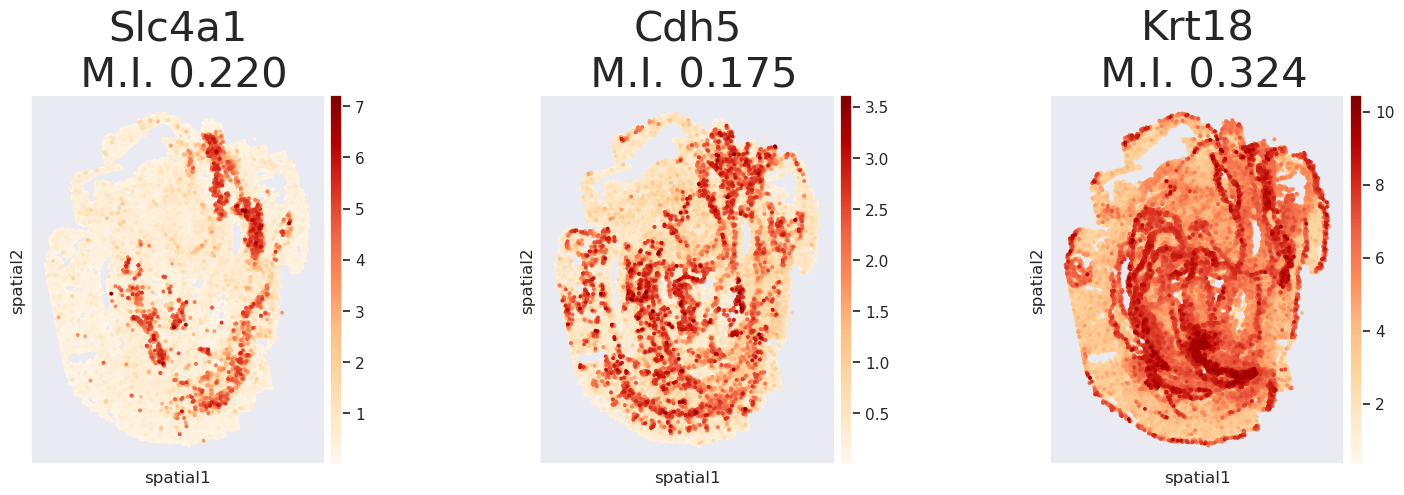

In [9]:
plot_genes(['Slc4a1', 'Cdh5', 'Krt18'], dict_adata['TransImpSpa'], is_I=True, dpi=100)